# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan

## Initial Set up
### Load packages

In [ ]:
## Load Libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os
import pandas as pd
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
from sklearn.metrics import classification_report

torch.__version__

'1.8.1+cu101'

##### Mount google drive

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')


We are using GPU.


In [ ]:
drive.mount('/content/gdrives')

Mounted at /content/gdrives


### Select Drive Path for Teammates

**Values :** 
- rebecca : Rebecca's drive config
- nirav : Nirav's drive config

In [ ]:
## Input name to get correct drive path
name = input()
if name == 'rebecca':
  data_path = '/content/gdrives/MyDrive/COMP5329_attempt2'
elif name == 'nirav': 
  data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

nirav


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - 2 different method per user (Rebecca and Nirav) due to drive paths
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
if name == 'nirav':
  class load_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None):
          with open(root_dir+'/'+annotation_file) as train: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
            train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

          self.root_dir = root_dir
          self.annotations = train_labels
          self.transform = transform

      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index, 0]
          img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")
          split_label = self.annotations.iloc[index, 1].split()
          num_labels = list(map(int, split_label))
          label = torch.LongTensor(num_labels) - 1

          # One Hot encoding Target labels
          one_hot_labels = torch.zeros(size=([19]), dtype=torch.float64)
          y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)

          if self.transform is not None:
              img = self.transform(img)

          return (img, y_label)

elif name == 'rebecca':
  class load_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None):
          with open(root_dir+'/'+annotation_file) as train: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
            train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

          self.root_dir = root_dir
          self.annotations = train_labels
          self.transform = transform

      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index, 0]
          val_temp = val_temp = int(re.search('^\d+\.', img_id).group(0)[:-1])
          if val_temp < 5000: 
            folder_dir = 'folder_1'
          elif val_temp < 10000: 
            folder_dir = 'folder_2'
          elif val_temp < 15000: 
            folder_dir = 'folder_3'
          elif val_temp < 20000: 
            folder_dir = 'folder_4'
          elif val_temp < 25000: 
            folder_dir = 'folder_5'
          elif val_temp < 30000:
            folder_dir = 'folder_6'
          img = Image.open(os.path.join(self.root_dir+'/uploads/'+folder_dir, img_id)).convert("RGB")
          split_label = self.annotations.iloc[index, 1].split()
          num_labels = list(map(int, split_label))
          label = torch.LongTensor(num_labels) - 1
          one_hot_labels = torch.zeros(size=([19]), dtype=torch.float64)
          # print(label, self.one_hot_labels.shape, label.shape)
          y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
          # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

          if self.transform is not None:
              img = self.transform(img)

          return (img, y_label)

if name == 'nirav':
  class load_test_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None): 
          with open(root_dir + '/' + annotation_file) as test: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
            test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

          self.root_dir = root_dir
          self.annotations = test_labels
          self.transform = transform
        
      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index,0]
          img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")

          if self.transform is not None: 
              img = self.transform(img)

          return (img)

elif name == 'rebecca':
  class load_test_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None): 
          with open(root_dir + '/' + annotation_file) as test: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
            test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

          self.root_dir = root_dir
          self.annotations = test_labels
          self.transform = transform
        
      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index,0]
          img = Image.open(os.path.join(self.root_dir+'/test_data/test_set', img_id)).convert("RGB")

          if self.transform is not None: 
              img = self.transform(img)

          return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
batch_size = 64
num_workers = 2
pin_memory = True
shuffle=True

kwargs = {'num_workers': num_workers, 'pin_memory': pin_memory} if use_cuda else {}
kwargs['batch_size'] = batch_size  # Batch size used during training.

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                # transforms.RandomHorizontalFlip(),
                                # transforms.RandomVerticalFlip(),
                                # transforms.RandomRotation(degrees=[-30, 30]),
                                # transforms.ColorJitter(brightness=0.4),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

test_transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

raw_dataset = load_data(data_path,"train.csv",transform=transform)
test_dataset = load_test_data(data_path, "test.csv", transform=test_transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )
print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)

23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([64, 3, 224, 224])
No. images loaded:  24000


## Exploratory Dataset Analysis

#### Training Labels

In [ ]:
training_indices = raw_dataset.annotations['Labels'][train_set.indices]
ti_split = training_indices.str.split()
t_counts = ti_split.explode().value_counts()
t_counts.index = t_counts.index.astype(int)
t_cnt = t_counts.sort_index()
print(t_cnt)
t_cnt = t_cnt.to_numpy()
total_cnt = np.insert(t_cnt,11,0) # for missing label 12, inserting 0
# print(type(total_cnt), len(total_cnt), total_cnt)



1     18224
2       923
3      3496
4      1007
5       915
6      1129
7       982
8      1750
9       845
10     1194
11      492
13      468
14      201
15     1582
16      881
17     1151
18     1205
19      827
Name: Labels, dtype: int64


#### Weight calculation per sample class

In [ ]:
class_counts = total_cnt
num_samples = sum(class_counts)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
# weights = [class_weights[labels_temp[i]] for i in range(int(num_samples))]
class_weights[11] = 0
print(type(class_weights),class_weights)
smp = np.array(class_weights)
# print(type(smp),smp)
sss = torch.from_numpy(smp).float().to(dev)
print(type(sss),sss)


<class 'list'> [2.0452151009657595, 40.38136511375948, 10.661327231121282, 37.012909632572, 40.734426229508195, 33.0132860938884, 37.955193482688394, 21.298285714285715, 44.10887573964497, 31.21608040201005, 75.7560975609756, 0, 79.64102564102564, 185.43283582089552, 23.560050568900127, 42.306469920544835, 32.382276281494356, 30.931120331950208, 45.0689238210399]
<class 'torch.Tensor'> tensor([  2.0452,  40.3814,  10.6613,  37.0129,  40.7344,  33.0133,  37.9552,
         21.2983,  44.1089,  31.2161,  75.7561,   0.0000,  79.6410, 185.4328,
         23.5601,  42.3065,  32.3823,  30.9311,  45.0689], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


#### Training Label Distribution

<BarContainer object of 19 artists>

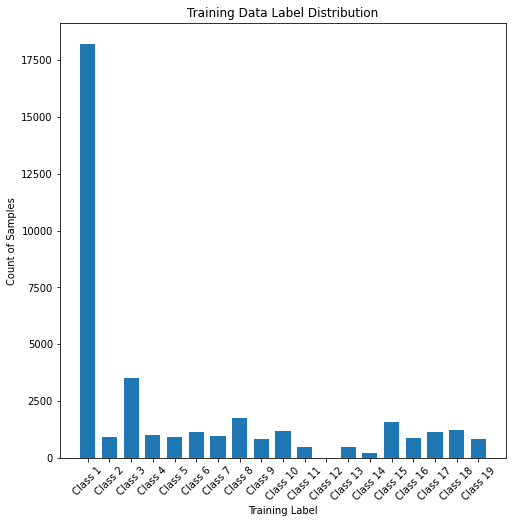

In [ ]:
%matplotlib inline
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 
'Class 16', 'Class 17', 'Class 18','Class 19']
plt.rcParams['figure.figsize'] = [8, 8]
plt.title('Training Data Label Distribution')
plt.ylabel('Count of Samples')
plt.xlabel('Training Label')
plt.xticks(np.arange(0,19,1), class_labels, rotation=45)
plt.bar(np.arange(len(total_cnt)),total_cnt, width=0.7)


### Functions and definitions necessary for evaluation

In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [ ]:
## Create list of class names for matching in the evaluation and prediction stage
class_names = np.array(list(range(1, 20)))

## Modelling stage:
### Implement AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=19, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet, self).__init__()
        
        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid(),
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling layer
        x = self.avgpool(x)
        # flatten feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        return x

### Model Training with hypermarameters

In [ ]:
## Initialise and train an alexnet model
model_alexnet = AlexNet().to(dev)
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=sss)
optimizer = optim.Adam(model_alexnet.parameters(), lr = 0.001)

train_loss_tracker = []
train_accuracy_tracker = []
epoch_loss = []

epochs = 30
for epoch in range(epochs):
  print(f'Epoch no. {epoch + 1}')

  start = time.time()
  ep_loss = 0.0
  ep_acc = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    inputs = inputs.to(dev)
    labels = labels.to(dev)

    optimizer.zero_grad()

    outputs = model_alexnet(inputs)
    loss = criterion(outputs.float(), labels.float())
    ep_loss += loss

    acc = accuracy(outputs.to('cpu'), labels.to('cpu'))
    ep_acc += acc
    loss.backward()
    optimizer.step()
  
  train_loss_tracker.append(ep_loss/(i+1))
  train_accuracy_tracker.append(ep_acc/(i+1))
  print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
  print(f'time taken to run: {time.time() - start}')
  epoch_loss.append(round(ep_loss.item()/(i+1),2))

Epoch no. 1
Loss: 1.633, Accuracy: 17.018
time taken to run: 6514.731717586517
Epoch no. 2
Loss: 1.633, Accuracy: 17.098
time taken to run: 66.8106620311737
Epoch no. 3
Loss: 1.633, Accuracy: 17.097
time taken to run: 67.54105949401855
Epoch no. 4
Loss: 1.633, Accuracy: 17.098
time taken to run: 67.35512137413025
Epoch no. 5
Loss: 1.633, Accuracy: 17.098
time taken to run: 66.6331524848938
Epoch no. 6
Loss: 1.633, Accuracy: 17.097
time taken to run: 65.01987648010254
Epoch no. 7
Loss: 1.633, Accuracy: 17.098
time taken to run: 67.07748413085938
Epoch no. 8
Loss: 1.633, Accuracy: 17.098
time taken to run: 65.52470278739929
Epoch no. 9
Loss: 1.633, Accuracy: 17.098
time taken to run: 65.0981388092041
Epoch no. 10
Loss: 1.633, Accuracy: 17.098
time taken to run: 63.4715518951416
Epoch no. 11
Loss: 1.633, Accuracy: 17.098
time taken to run: 62.67775368690491
Epoch no. 12
Loss: 1.633, Accuracy: 17.098
time taken to run: 63.91177010536194
Epoch no. 13
Loss: 1.633, Accuracy: 17.098
time taken

In [ ]:
torch.save(model_alexnet.state_dict(), data_path+'/trained_alexnet_with_aug_wd.pth')

#### Visualize Training Loss

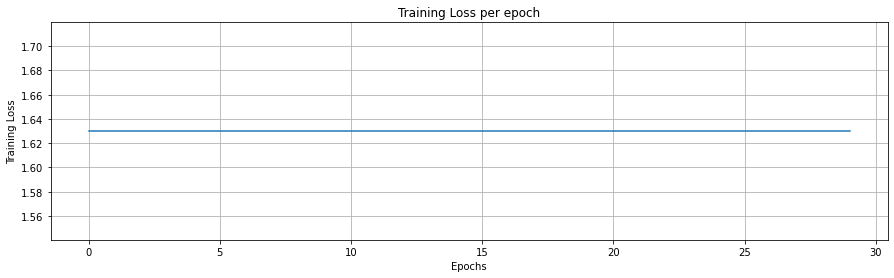

In [ ]:
plt.figure(figsize=(15,4))
plt.title('Training Loss per epoch')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.plot(epoch_loss)
plt.grid()

In [ ]:
model_alexnet = AlexNet()
model_alexnet.load_state_dict(torch.load(data_path+'/trained_alexnet_with_aug_wd.pth'))
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.BCELoss()
# model_alexnet.to(dev)
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Model Validation on validation set data

In [ ]:
# model_alexnet.cpu()
model_alexnet.eval()

pred_results = np.array(range(1,20)).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)

validation_loss = 0.0
validation_accuracy = 0.0

for step, (inputs, label) in enumerate(validation_loader):
  print(step)
  inputs = torch.Tensor.cpu(inputs)#.to(dev)
  label = torch.Tensor.cpu(label)#.to(dev)

  # Make predictions
  y_pred = model_alexnet(inputs)
  preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
  preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
  targets_np = torch.Tensor.cpu(label).detach().numpy()

  # Store predictions
  pred_results = np.concatenate((pred_results, preds_np), axis=0)
  target_results = np.concatenate((target_results, targets_np), axis=0)

  acc = accuracy(y_pred.cpu(), label.cpu())
  validation_loss += criterion(y_pred.float(), label.float())
  validation_accuracy += acc

average_validation_loss = validation_loss/(len(validation_loader))
average_validation_accuracy = validation_accuracy/(len(validation_loader))

print(f'Average validation loss: {average_validation_loss}')
print(f'Average validation accuracy: {average_validation_accuracy}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
Average validation loss: 10.014114379882812
Average validation accuracy: 17.097318498189228


### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.76      1.00      0.86      4570
          02       1.00      0.00      0.00       239
          03       1.00      0.00      0.00       868
          04       1.00      0.00      0.00       265
          05       1.00      0.00      0.00       215
          06       1.00      0.00      0.00       265
          07       1.00      0.00      0.00       239
          08       1.00      0.00      0.00       460
          09       1.00      0.00      0.00       197
          10       1.00      0.00      0.00       277
          11       1.00      0.00      0.00       112
          12       1.00      1.00      1.00         0
          13       1.00      0.00      0.00       137
          14       1.00      0.00      0.00        50
          15   

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, coverage_error
coverage_error(target_results[1:], pred_results[1:])

10.32855475912652

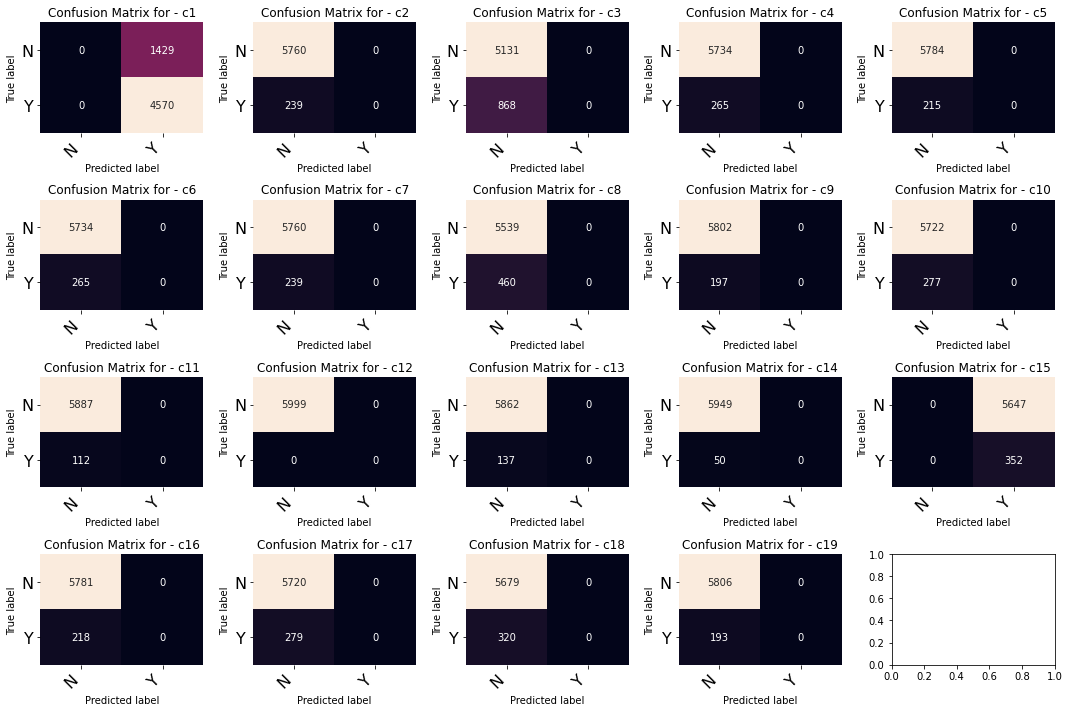

In [ ]:
# multilabel_confusion_matrix(target_results[1:], pred_results[1:])

multi_matrix = multilabel_confusion_matrix(target_results[1:], pred_results[1:])

labels = ["".join("c" + str(i)) for i in range(1, 20)]

def display_heatmap(confusion_matrix, axes, class_labels, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for - " + class_labels)


fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), multi_matrix, labels):
        display_heatmap(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                shuffle=False, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_images = next(iter(test_loader))

print('No. Test images loaded: ',len(test_loader)*batch_size)

No. Test images loaded:  10048


In [ ]:
torch.cuda.empty_cache()

In [ ]:
## Make test predictions
model_alexnet.eval()
pred_results_test = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []

for step, (inputs) in enumerate(test_loader):
    if step % 100 == 0:
      print(step)
    images.append(test_dataset.annotations.ImageID[step])
    inputs = torch.Tensor.cpu(inputs)#.to(dev)
    # inputs = inputs.unsqueeze(0)

    y_pred = model_alexnet(inputs)

    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()

    preds_classes = class_names[preds_np[0] == 1.0]
    preds_string = [str(int) for int in preds_classes]
    
    predictions.append(' '.join(preds_string))
    pred_results_test = np.concatenate((pred_results_test, preds_np), axis=0)

prediction_upload = pd.DataFrame(zip(images, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_aug_wd_test_predictions.csv', index = False)
prediction_upload.head()

0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe846729950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
